In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install pandas_profiling 
import pandas_profiling 
import scipy.stats as stats
import statsmodels as sm
%matplotlib inline

import sklearn as sk

plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')

In [47]:
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

In [25]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [5]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [6]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

#### Loading Datasets

In [7]:
credit_card=pd.read_excel('Data Set.xlsx')
credit_card.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [9]:
credit_card.shape

(5000, 130)

In [ ]:
pandas_profiling.ProfileReport(credit_card)

Render HTML:   0%|                                                                               | 0/1 [00:00<?, ?it/s]

In [14]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


### Data Cleaning

In [15]:
credit_card.drop(columns=['custid','birthmonth'],inplace=True)

In [16]:
credit_card.columns

Index(['region', 'townsize', 'gender', 'age', 'agecat', 'ed', 'edcat',
       'jobcat', 'union', 'employ',
       ...
       'owncd', 'ownpda', 'ownpc', 'ownipod', 'owngame', 'ownfax', 'news',
       'response_01', 'response_02', 'response_03'],
      dtype='object', length=128)

In [17]:
# defining categorical variables
for x in ['gender','jobcat', 'union','retire','default','marital','homeown','hometype','carown','cartype','carcatvalue','carbought','carbuy',
                 'commutecat','reason','polview','card','cardtype','cardbenefit','cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee',
                 'card2tenurecat','bfast','internet']:
    credit_card[x] = credit_card[x].astype('object')

In [18]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 128 entries, region to response_03
dtypes: float64(31), int64(69), object(28)
memory usage: 4.9+ MB


In [19]:
# separation of continuous variables and categorical variables

In [20]:
conti_vars=credit_card.select_dtypes(['float64','int64'])
cat_vars=credit_card.select_dtypes('object')
conti_vars.head()

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,1,2.0,20,2,15,3,0,1,31,3.433987,...,0,0,0,1,1,0,0,0,1,0
1,5,5.0,22,2,17,4,0,1,15,2.708050,...,1,1,1,1,1,1,1,0,0,0
2,3,4.0,67,6,14,2,16,5,35,3.555348,...,1,0,0,0,0,0,1,0,0,0
3,4,3.0,23,2,16,3,0,1,20,2.995732,...,1,0,1,1,1,0,1,1,0,0
4,2,2.0,26,3,16,3,1,1,23,3.135494,...,1,0,1,0,1,0,0,0,1,0


In [21]:
cat_vars.head()

,gender,jobcat,union,retire,default,marital,homeown,hometype,carown,cartype,...,cardbenefit,cardfee,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenurecat,bfast,internet
0,1,1,1,0,1,0,0,2,1,0,...,1,0,2,5,3,1,0,2,3,0
1,0,2,0,0,1,0,1,3,1,1,...,1,0,2,4,1,3,0,2,1,4
2,1,2,0,0,0,1,1,1,1,1,...,4,0,5,4,1,3,0,5,3,0
3,0,2,0,0,1,1,1,3,1,1,...,4,0,2,3,2,4,0,2,1,2
4,0,2,0,0,0,1,0,2,0,1,...,1,0,3,1,3,2,0,3,3,3


In [26]:
# summary of continuous variables
conti_vars.apply(continuous_var_summary).T.round(1).sort_values('NMISS',ascending=False).head(10)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
lnwiremon,1344.0,3656.0,4845.1,3.6,3.6,0.4,0.2,2.5,2.8,3.0,3.1,3.3,3.6,3.9,4.1,4.3,4.6,5.2
lnwireten,1344.0,3656.0,9150.1,6.8,7.1,1.3,1.6,2.5,3.0,4.1,4.9,6.2,7.1,7.8,8.1,8.3,8.7,9.5
lnequipten,1704.0,3296.0,11497.4,6.7,7.1,1.2,1.4,2.5,3.2,4.3,5.0,6.2,7.1,7.6,8.0,8.1,8.4,8.8
lnequipmon,1704.0,3296.0,6134.8,3.6,3.6,0.3,0.1,2.8,3.0,3.1,3.2,3.4,3.6,3.8,4.0,4.1,4.3,4.7
lntollten,2378.0,2622.0,15658.6,6.6,6.9,1.2,1.5,2.2,2.8,4.2,4.8,5.9,6.9,7.5,7.9,8.1,8.4,8.8
lntollmon,2378.0,2622.0,7712.4,3.2,3.2,0.4,0.2,2.1,2.3,2.6,2.7,3.0,3.2,3.5,3.8,3.9,4.2,4.6
lncardten,3578.0,1422.0,22993.3,6.4,6.6,1.2,1.4,1.6,2.5,4.1,4.9,5.9,6.6,7.2,7.7,7.9,8.4,9.5
lncardmon,3581.0,1419.0,10419.8,2.9,2.9,0.6,0.3,1.2,1.7,2.0,2.2,2.5,2.9,3.3,3.6,3.8,4.2,5.2
lnlongten,4997.0,3.0,28039.7,5.6,5.9,1.6,2.7,-0.1,0.9,2.5,3.3,4.7,5.9,6.8,7.5,7.9,8.5,9.5
longten,4997.0,3.0,3542232.2,708.9,350.0,979.3,959011.0,0.9,2.4,12.6,28.3,104.6,350.0,913.8,1808.8,2567.6,4689.1,13046.5


In [27]:
# dropping variables having large number of missing values i.e. having missing values greater than 25%  

In [28]:
conti_vars.drop(columns=['lnwiremon','lnwireten','lnequipten','lnequipmon','lntollten','lntollmon','lncardten','lncardmon'],inplace=True)

In [29]:
# summary of categorical variables
cat_vars.apply(categorical_var_summary).T

,N,NMISS,MODE,FREQ,PERCENT
gender,5000.0,0.0,1.0,2518.0,50.36
jobcat,5000.0,0.0,2.0,1640.0,32.80
union,5000.0,0.0,0.0,4244.0,84.88
retire,5000.0,0.0,0.0,4262.0,85.24
default,5000.0,0.0,0.0,3829.0,76.58
marital,5000.0,0.0,0.0,2599.0,51.98
homeown,5000.0,0.0,1.0,3148.0,62.96
hometype,5000.0,0.0,1.0,2265.0,45.30
carown,5000.0,0.0,1.0,3704.0,74.08
cartype,5000.0,0.0,0.0,2287.0,45.74


### Outliers Treatment

In [30]:
# continuous variables
conti_vars = conti_vars.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [31]:
conti_vars.apply(continuous_var_summary).T.round(2)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
region,5000.0,0.0,15007.0,3.00,3.0,1.42,2.02,1.0,1.0,1.0,1.0,2.0,3.0,4.0,5.0,5.0,5.0,5.0
townsize,4998.0,2.0,13431.0,2.69,3.0,1.43,2.03,1.0,1.0,1.0,1.0,1.0,3.0,4.0,5.0,5.0,5.0,5.0
age,5000.0,0.0,235128.0,47.03,47.0,17.77,315.78,18.0,18.0,20.0,23.0,31.0,47.0,62.0,72.0,76.0,79.0,79.0
agecat,5000.0,0.0,21194.0,4.24,4.0,1.31,1.71,2.0,2.0,2.0,2.0,3.0,4.0,5.0,6.0,6.0,6.0,6.0
ed,5000.0,0.0,72721.0,14.54,14.0,3.24,10.51,8.0,8.0,9.0,10.0,12.0,14.0,17.0,19.0,20.0,21.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ownfax,5000.0,0.0,894.0,0.18,0.0,0.38,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
news,5000.0,0.0,2363.0,0.47,0.0,0.50,0.25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
response_01,5000.0,0.0,418.0,0.08,0.0,0.28,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
response_02,5000.0,0.0,649.0,0.13,0.0,0.34,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


### Missing value imputation

In [33]:
#for categorical and continuous variables
conti_vars = conti_vars.apply(missing_imputation)
cat_vars = cat_vars.apply(missing_imputation)

In [34]:
conti_vars.apply(continuous_var_summary).T.round(1)
cat_vars.apply(categorical_var_summary).T.round(1)

,N,NMISS,MODE,FREQ,PERCENT
gender,5000.0,0.0,1.0,2518.0,50.4
jobcat,5000.0,0.0,2.0,1640.0,32.8
union,5000.0,0.0,0.0,4244.0,84.9
retire,5000.0,0.0,0.0,4262.0,85.2
default,5000.0,0.0,0.0,3829.0,76.6
marital,5000.0,0.0,0.0,2599.0,52.0
homeown,5000.0,0.0,1.0,3148.0,63.0
hometype,5000.0,0.0,1.0,2265.0,45.3
carown,5000.0,0.0,1.0,3704.0,74.1
cartype,5000.0,0.0,0.0,2287.0,45.7


### Dummy Creation

In [35]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [36]:
cat_vars = credit_card[['gender','jobcat', 'union','retire','default','marital','homeown','hometype','carown','cartype','carcatvalue','carbought','carbuy',
                 'commutecat','reason','polview','card','cardtype','cardbenefit','cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee',
                 'card2tenurecat','bfast','internet']]

# for c_feature in categorical_features
for c_feature in ['gender','jobcat', 'union','retire','default','marital','homeown','hometype','carown','cartype','carcatvalue','carbought','carbuy',
                 'commutecat','reason','polview','card','cardtype','cardbenefit','cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee',
                 'card2tenurecat','bfast','internet']:
    cat_vars[c_feature] = cat_vars[c_feature].astype('category')
    cat_vars = create_dummies(cat_vars, c_feature)
 

cat_vars.head()

C:\Users\Vishal Parihar\AppData\Local\Temp\ipykernel_20372\1584126451.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_vars[c_feature] = cat_vars[c_feature].astype('category')


,gender_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,retire_1,default_1,marital_1,...,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4
0,1,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0


In [37]:
credit_cards = pd.concat([conti_vars, cat_vars], axis = 1)
credit_cards.head()

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4
0,1,2.0,20,2,15.0,3,0.0,1,31.0,3.433987,...,1,0,0,0,0,1,0,0,0,0
1,5,5.0,22,2,17.0,4,0.0,1,15.0,2.708050,...,1,0,0,0,0,0,0,0,0,1
2,3,4.0,67,6,14.0,2,16.0,5,35.0,3.555348,...,0,0,0,1,0,1,0,0,0,0
3,4,3.0,23,2,16.0,3,0.0,1,20.0,2.995732,...,1,0,0,0,0,0,0,1,0,0
4,2,2.0,26,3,16.0,3,1.0,1,23.0,3.135494,...,0,1,0,0,0,1,0,0,1,0


In [38]:
credit_cards['cards_spent']=credit_cards.cardspent+credit_cards.card2spent
credit_cards.cards_spent.head()
credit_cards.drop(columns=['cardspent','card2spent'],inplace=True)

### checking Assumption for Linear regression

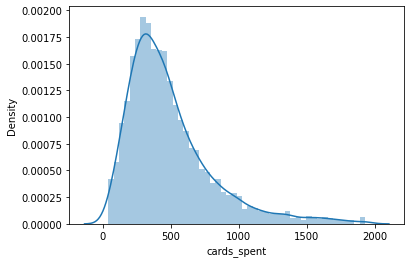

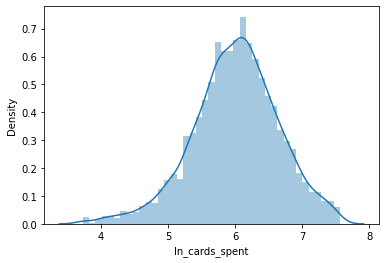

In [41]:
sns.distplot(credit_cards.cards_spent)
plt.show()
credit_cards['ln_cards_spent']=np.log(credit_cards['cards_spent']+1)
sns.distplot(credit_cards.ln_cards_spent)
plt.show()

In [42]:
# correlation matrix
corrm = credit_cards.corr()
#corrm.to_csv('corrm.csv')
corrm

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4,cards_spent,ln_cards_spent
region,1.000000,0.414030,-0.026525,-0.018455,0.013850,0.015710,-0.010204,-0.009345,0.036594,0.041040,...,0.001934,0.001824,-0.025937,0.022485,-0.011312,0.017262,0.011343,0.008395,0.043054,0.039457
townsize,0.414030,1.000000,-0.075454,-0.069069,0.002901,0.003684,-0.059279,-0.058155,-0.009513,0.000895,...,-0.009898,-0.028444,-0.052081,0.033830,-0.019763,-0.007458,-0.012535,0.022101,-0.007873,0.007297
age,-0.026525,-0.075454,1.000000,0.969879,-0.093966,-0.081129,0.705515,0.739573,0.208286,0.142984,...,0.036604,0.583146,0.571241,-0.178583,-0.019941,-0.048072,-0.049059,-0.076481,0.031339,0.005940
agecat,-0.018455,-0.069069,0.969879,1.000000,-0.078331,-0.064124,0.679902,0.732246,0.234081,0.190188,...,0.050874,0.570096,0.541792,-0.158078,-0.011759,-0.041756,-0.051243,-0.071654,0.051409,0.029185
ed,0.013850,0.002901,-0.093966,-0.078331,1.000000,0.966489,-0.214669,-0.197841,0.186802,0.206332,...,0.028935,-0.094779,-0.073943,0.044166,0.066815,0.153683,0.185075,0.288958,0.100796,0.098199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
internet_2,0.017262,-0.007458,-0.048072,-0.041756,0.153683,0.145535,-0.060917,-0.054881,-0.012050,-0.003360,...,-0.015802,-0.044333,-0.030826,0.014085,-0.149686,1.000000,-0.128914,-0.127317,-0.002601,-0.007668
internet_3,0.011343,-0.012535,-0.049059,-0.051243,0.185075,0.183713,-0.063521,-0.062644,0.029947,0.028140,...,0.001895,-0.025326,-0.035417,0.020052,-0.157736,-0.128914,1.000000,-0.134165,0.053317,0.045823
internet_4,0.008395,0.022101,-0.076481,-0.071654,0.288958,0.282396,-0.090103,-0.086312,0.056976,0.057465,...,0.003605,-0.063939,-0.045169,0.026509,-0.155782,-0.127317,-0.134165,1.000000,0.044798,0.055503
cards_spent,0.043054,-0.007873,0.031339,0.051409,0.100796,0.098409,0.090854,0.115397,0.378967,0.398263,...,0.032700,0.058797,-0.018725,0.032827,-0.014262,-0.002601,0.053317,0.044798,1.000000,0.909764


<AxesSubplot:>

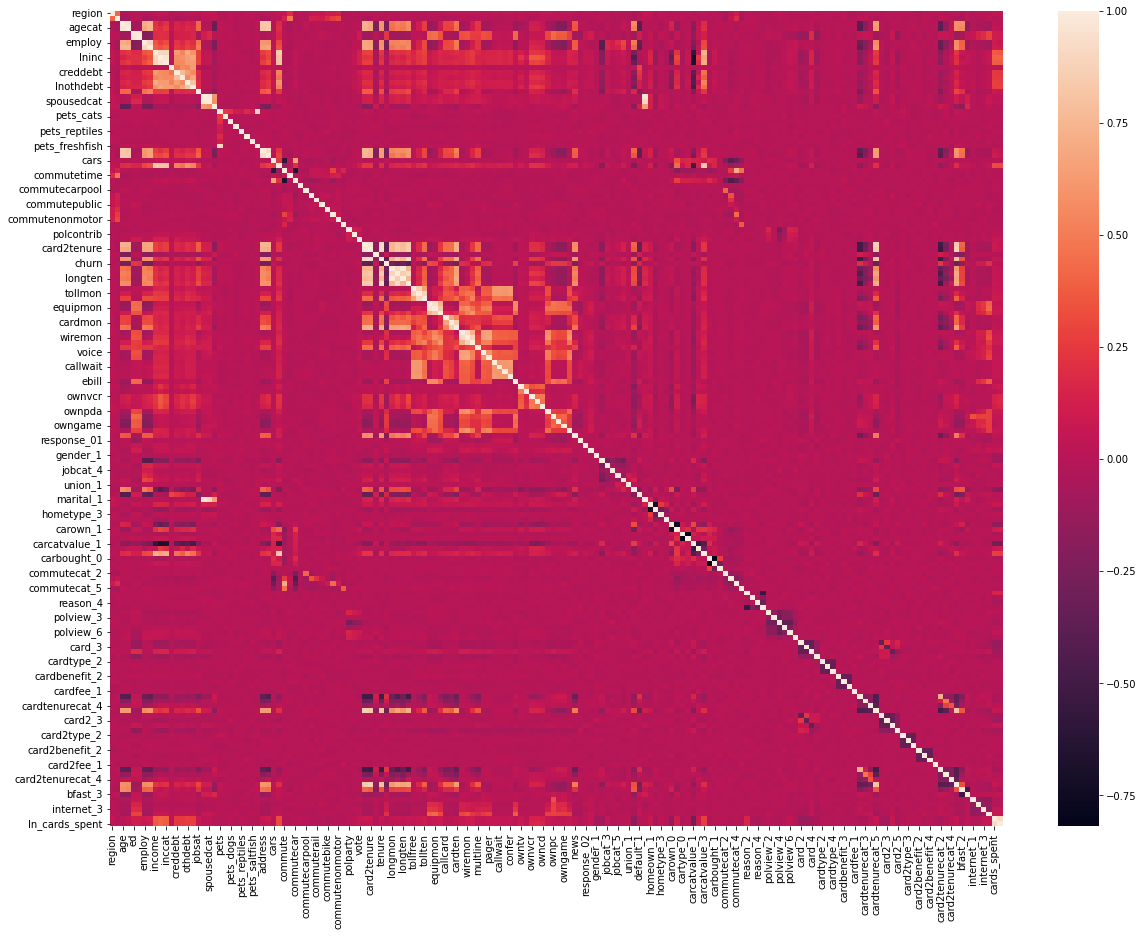

In [44]:
# heatmap showing correlation
plt.figure(figsize = (20, 15))
sns.heatmap(credit_cards.corr())

In [45]:
#We cannot find any correlation between variables using heatmap. Therefore we will not drop variables using heatmap.

### Model Building

In [50]:
#Step1: divide the data into training and testing and separate out Y and X variables
train,test=train_test_split(credit_cards,test_size=0.3,random_state=56789)
test.head(10)

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4,cards_spent,ln_cards_spent
4133,4,3.0,35,4,16.0,3,2.0,2,41.0,3.713572,...,0,1,0,0,0,1,0,0,539.0500,6.291662
3771,3,1.0,47,4,13.0,2,18.0,5,113.0,4.727388,...,0,1,0,0,0,0,0,0,1537.3098,7.338440
26,5,4.0,26,3,16.0,3,0.0,1,24.0,3.178054,...,0,0,0,1,0,0,0,1,548.6700,6.309318
2049,5,5.0,51,5,15.0,3,4.0,2,29.0,3.367296,...,0,0,0,0,0,0,0,0,308.1700,5.733891
3385,5,5.0,57,5,15.0,3,8.0,3,220.0,5.393628,...,0,1,0,0,0,0,0,0,535.5500,6.285160
2240,3,3.0,70,6,11.0,1,39.0,5,15.0,2.708050,...,0,1,1,0,0,0,0,0,218.4900,5.391307
671,4,1.0,23,2,16.0,3,1.0,1,22.0,3.091042,...,0,0,0,0,0,0,1,0,608.2100,6.412163
3049,3,5.0,60,5,19.0,4,22.0,5,115.0,4.744932,...,0,1,0,1,1,0,0,0,710.7300,6.567699
3543,4,1.0,49,4,14.0,2,16.0,5,103.0,4.634729,...,1,0,0,0,0,0,0,1,447.5000,6.105909
522,3,4.0,45,4,16.0,3,12.0,4,41.0,3.713572,...,0,1,0,1,1,0,0,0,448.6800,6.108536


In [51]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  3500  |  No of obs in testing:  1500


In [52]:
train.columns= [phrase.strip().replace('-', '') for phrase in train.columns]
train.columns

Index(['region', 'townsize', 'age', 'agecat', 'ed', 'edcat', 'employ',
       'empcat', 'income', 'lninc',
       ...
       'card2tenurecat_4', 'card2tenurecat_5', 'bfast_2', 'bfast_3',
       'internet_1', 'internet_2', 'internet_3', 'internet_4', 'cards_spent',
       'ln_cards_spent'],
      dtype='object', length=166)

In [53]:
all_columns = "+".join(train.columns.difference( ['ln_cards_spent'] ))

print(all_columns)

#my_formula = 'ln_cards_spent' + all_columns

#print(my_formula)

active+address+addresscat+age+agecat+bfast_2+bfast_3+callcard+callid+callwait+carbought_0+carbought_1+carbuy_1+carcatvalue_1+carcatvalue_2+carcatvalue_3+card2_2+card2_3+card2_4+card2_5+card2benefit_2+card2benefit_3+card2benefit_4+card2fee_1+card2tenure+card2tenurecat_2+card2tenurecat_3+card2tenurecat_4+card2tenurecat_5+card2type_2+card2type_3+card2type_4+card_2+card_3+card_4+card_5+cardbenefit_2+cardbenefit_3+cardbenefit_4+cardfee_1+cardmon+cards_spent+cardten+cardtenure+cardtenurecat_2+cardtenurecat_3+cardtenurecat_4+cardtenurecat_5+cardtype_2+cardtype_3+cardtype_4+carown_0+carown_1+cars+cartype_0+cartype_1+carvalue+churn+commute+commutebike+commutebus+commutecar+commutecarpool+commutecat_2+commutecat_3+commutecat_4+commutecat_5+commutemotorcycle+commutenonmotor+commutepublic+commuterail+commutetime+commutewalk+confer+creddebt+debtinc+default_1+ebill+ed+edcat+empcat+employ+equip+equipmon+equipten+forward+gender_1+homeown_1+hometype_2+hometype_3+hometype_4+hourstv+inccat+income+interne

### OLS Model using Linear Regression

In [54]:
import statsmodels.formula.api as smf                # #simultaneously reducing least contributing variables as per p value

lm=smf.ols('''ln_cards_spent ~addresscat+
card2_2+card2_3+card2_4+card2_5+card2benefit_3+
card2tenurecat_3+
card_2+card_3+card_4+card_5+
cardtenurecat_3+cardtype_2+
cartype_0+churn+
commutenonmotor+
debtinc+default_1+ebill+edcat+gender_1+
hometype_3+inccat+internet_3+internet_4+
lncreddebt+
othdebt+owndvd+ownvcr+
pets_reptiles+pets_saltfish+polcontrib+
polview_7+reason_2+reason_9+region+retire_1+
union_1
''',train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ln_cards_spent   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     50.95
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          3.92e-300
Time:                        18:40:05   Log-Likelihood:                -2686.6
No. Observations:                3500   AIC:                             5451.
Df Residuals:                    3461   BIC:                             5691.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.4100      0.079     80.730      0.000       6.254       6.566
addresscat          -0.0131      0.009     -1.413      0.158      -0.031       0.005
card2_2             -0.4145      0.029    -14.191      0.000      -0.472      -0.357
card2_3             -0.4182      0.029    -14.286      0.000      -0.476      -0.361
card2_4             -0.4621      0.032    -14.462      0.000      -0.525      -0.399
card2_5             -0.2859      0.043     -6.722      0.000      -0.369      -0.202
card2benefit_3      -0.0671      0.020     -3.286      0.001      -0.107      -0.027
card2tenurecat_3     0.0395      0.026      1.517      0.129      -0.012       0.091
card_2              -0.6158      0.029    -21.311      0.000      -0.673      -0.559
card_3              -0.6224      0.029    -21.355      0.000      -0.680      -0.565
card_4              -0.7105      0.030    -23.780      0.000      -0.769      -0.652
card_5              -0.5152      0.049    -10.497      0.000      -0.611      -0.419
cardtenurecat_3     -0.0540      0.028     -1.931      0.054      -0.109       0.001
cardtype_2           0.0329      0.021      1.605      0.109      -0.007       0.073
cartype_0           -0.0376      0.018     -2.101      0.036      -0.073      -0.003
churn                0.0500      0.022      2.232      0.026       0.006       0.094
commutenonmotor     -0.0591      0.039     -1.521      0.128      -0.135       0.017
debtinc             -0.0094      0.003     -3.697      0.000      -0.014      -0.004
default_1            0.0335      0.024      1.379      0.168      -0.014       0.081
ebill               -0.0326      0.022     -1.451      0.147      -0.077       0.011
edcat               -0.0239      0.009     -2.722      0.007      -0.041      -0.007
gender_1            -0.0432      0.018     -2.417      0.016      -0.078      -0.008
hometype_3           0.0321      0.023      1.390      0.165      -0.013       0.077
inccat               0.1193      0.015      8.073      0.000       0.090       0.148
internet_3           0.0591      0.029      2.041      0.041       0.002       0.116
internet_4           0.0618      0.032      1.942      0.052      -0.001       0.124
lncreddebt           0.0487      0.012      4.104      0.000       0.025       0.072
othdebt              0.0128      0.004      3.364      0.001       0.005       0.020
owndvd               0.1008      0.036      2.778      0.005       0.030       0.172
ownvcr               0.1009      0.037      2.706      0.007       0.028       0.174
pets_reptiles        0.0718      0.032      2.253      0.024       0.009       0.134
pets_saltfish        0.0661      0.041      1.599      0.110      -0.015       0.147
polcontrib           0.0396      0.021      1.861      0.063      -0.002       0.081
polview_7           -0.

#### VIF : checking Multicolinearity for all the variable

In [55]:
model_param='''ln_cards_spent ~addresscat+
card2_2+card2_3+card2_4+card2_5+card2benefit_3+
card2tenurecat_3+
card_2+card_3+card_4+card_5+
cardtenurecat_3+cardtype_2+
cartype_0+churn+
commutenonmotor+
debtinc+default_1+ebill+edcat+gender_1+
hometype_3+inccat+internet_3+internet_4+
lncreddebt+
othdebt+owndvd+ownvcr+
pets_reptiles+pets_saltfish+polcontrib+
polview_7+reason_2+reason_9+region+retire_1+
union_1
'''
# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# separate the Y and X variables
y, X = dmatrices(model_param, train, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the output
vif.round(1)

,Features,VIF Factor
0,Intercept,80.3
1,addresscat,1.9
2,card2_2,2.1
3,card2_3,2.2
4,card2_4,2.3
5,card2_5,1.5
6,card2benefit_3,1.0
7,card2tenurecat_3,1.3
8,card_2,2.0
9,card_3,2.0


In [56]:
# Step 4: predict the sales on the training data
train['pred_limit'] = np.exp(lm.predict(train))
train.head()

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4,cards_spent,ln_cards_spent,pred_limit
4361,2,1.0,21,2,16.0,3,0.0,1,28.0,3.332205,...,0,0,1,0,0,0,1,831.89,6.724902,700.552454
2519,2,2.0,29,3,12.0,2,2.0,2,24.0,3.178054,...,0,0,1,0,0,0,0,534.07,6.282398,510.839070
4837,1,2.0,27,3,17.0,4,0.0,1,22.0,3.091042,...,0,0,0,0,1,0,0,313.49,5.750952,263.285344
1334,3,5.0,57,5,15.0,3,21.0,5,111.0,4.709530,...,1,1,0,1,0,0,0,308.10,5.733665,372.806591
719,1,1.0,25,3,13.0,2,3.0,2,14.0,2.639057,...,0,0,1,1,0,0,0,341.05,5.834957,302.917108


In [57]:
# Step 5: predict the sales on the testing/validation data
test['pred_limit'] = np.exp(lm.predict(test))
test.head()

,region,townsize,age,agecat,ed,edcat,employ,empcat,income,lninc,...,card2tenurecat_5,bfast_2,bfast_3,internet_1,internet_2,internet_3,internet_4,cards_spent,ln_cards_spent,pred_limit
4133,4,3.0,35,4,16.0,3,2.0,2,41.0,3.713572,...,1,0,0,0,1,0,0,539.0500,6.291662,483.556981
3771,3,1.0,47,4,13.0,2,18.0,5,113.0,4.727388,...,1,0,0,0,0,0,0,1537.3098,7.338440,815.594536
26,5,4.0,26,3,16.0,3,0.0,1,24.0,3.178054,...,0,0,1,0,0,0,1,548.6700,6.309318,401.193542
2049,5,5.0,51,5,15.0,3,4.0,2,29.0,3.367296,...,0,0,0,0,0,0,0,308.1700,5.733891,335.961268
3385,5,5.0,57,5,15.0,3,8.0,3,220.0,5.393628,...,1,0,0,0,0,0,0,535.5500,6.285160,984.061535


In [58]:
# accuracy metrics (d. Decile Analysis: for validation of models - Business validation)
# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['pred_limit'], 10, labels = False)
test['Deciles'] = pd.qcut(test['pred_limit'], 10, labels = False)

# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'pred_limit']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_limit']
Actual_avg = train[['Deciles', 'ln_cards_spent']].groupby(train.Deciles).mean().sort_index(ascending = False)['ln_cards_spent']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'pred_limit']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_limit']
Actual_avg = test[['Deciles', 'ln_cards_spent']].groupby(test.Deciles).mean().sort_index(ascending = False)['ln_cards_spent']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# write the data into the file
#Decile_analysis_train.to_csv('Decile_analysis_train.csv')
#Decile_analysis_test.to_csv('Decile_analysis_test.csv')

In [59]:
Decile_analysis_train

,Deciles,pred_limit,ln_cards_spent
0,9,855.532237,6.738628
1,8,635.376505,6.450165
2,7,536.280815,6.258885
3,6,468.813478,6.138922
4,5,413.626333,6.026700
5,4,367.723441,5.939242
6,3,334.079128,5.824487
7,2,304.722763,5.712216
8,1,273.438481,5.644305
9,0,225.418910,5.376352


In [60]:
Decile_analysis_test

,Deciles,pred_limit,ln_cards_spent
0,9,897.243254,6.617238
1,8,635.282775,6.370348
2,7,534.208962,6.193616
3,6,467.415718,6.135334
4,5,408.669889,6.022780
5,4,364.310751,6.002965
6,3,329.631585,5.801526
7,2,300.511213,5.770472
8,1,266.019994,5.651872
9,0,224.091549,5.399882


#### checking for influential observation

In [61]:
from statsmodels.formula.api import ols
m = ols('''ln_cards_spent ~addresscat+
card2_2+card2_3+card2_4+card2_5+card2benefit_3+
card2tenurecat_3+
card_2+card_3+card_4+card_5+
cardtenurecat_3+cardtype_2+
cartype_0+churn+
commutenonmotor+
debtinc+default_1+ebill+edcat+gender_1+
hometype_3+inccat+internet_3+internet_4+
lncreddebt+
othdebt+owndvd+ownvcr+
pets_reptiles+pets_saltfish+polcontrib+
polview_7+reason_2+reason_9+region+retire_1+
union_1
''',train).fit()
infl=m.get_influence()
sm_fr=infl.summary_frame()

sm_fr

,dfb_Intercept,dfb_addresscat,dfb_card2_2,dfb_card2_3,dfb_card2_4,dfb_card2_5,dfb_card2benefit_3,dfb_card2tenurecat_3,dfb_card_2,dfb_card_3,...,dfb_reason_9,dfb_region,dfb_retire_1,dfb_union_1,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
4361,0.001505,-0.006456,0.005267,-0.003590,-0.005038,-0.001469,-0.003623,-0.001286,-0.007432,-0.011235,...,0.001500,-0.003781,0.004174,-0.003205,0.000031,0.331834,0.010784,0.034647,0.331791,0.034642
2519,0.002094,0.001569,-0.000562,-0.000572,0.001190,-0.000236,-0.000974,-0.000605,-0.002652,-0.002657,...,0.000539,-0.000903,-0.001289,-0.000577,0.000001,0.088697,0.006831,0.007356,0.088685,0.007355
4837,0.003015,-0.000649,0.006252,0.001416,0.000006,-0.000618,-0.003378,-0.001823,0.001539,0.007327,...,0.003234,-0.008198,-0.006175,-0.002370,0.000035,0.340934,0.011490,0.036757,0.340890,0.036753
1334,0.008470,-0.005864,-0.009853,-0.001339,-0.004690,-0.004625,-0.010299,-0.001407,-0.002998,0.000744,...,-0.003506,-0.000058,0.006732,-0.013836,0.000090,-0.362197,0.026124,-0.059321,-0.362151,-0.059314
719,0.006643,0.002467,-0.007907,-0.007540,-0.005341,-0.004642,0.006700,-0.007606,-0.002105,-0.002267,...,0.002110,-0.006000,-0.003236,-0.000720,0.000020,0.233362,0.013828,0.027633,0.233330,0.027630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,0.008964,-0.004752,-0.000816,-0.000466,0.003287,0.000020,0.005682,-0.001265,-0.005378,-0.005143,...,0.001323,-0.002683,-0.002111,-0.001604,0.000011,0.202746,0.010539,0.020924,0.202718,0.020921
1564,-0.012894,0.001340,0.039075,0.008962,0.017637,0.011985,0.045091,-0.040891,0.014918,-0.000698,...,0.012672,-0.037707,-0.000055,-0.009737,0.000519,1.459146,0.009418,0.142279,1.459384,0.142302
972,-0.001494,0.007176,0.000377,0.003512,-0.000738,-0.001024,0.006104,-0.001084,0.003465,0.000306,...,0.001469,0.002268,-0.005428,0.008259,0.000013,0.215364,0.010494,0.022179,0.215334,0.022176
2645,-0.010467,-0.007497,0.014668,0.013631,0.011505,0.007680,0.003543,0.001879,0.000767,0.001404,...,0.022782,0.006085,0.005220,0.002613,0.000058,-0.500017,0.009002,-0.047655,-0.499962,-0.047650


#### Reduced variable after applying Linear regression


In [62]:
features=['addresscat','carbought_1',
'card2_2','card2_3','card2_4','card2_5','card2benefit_3',
'card2tenurecat_3',
'card_2','card_3','card_4','card_5','cardmon',
'cardtype_2',
'cartype_0','carvalue','churn',
'debtinc','default_1','ebill','edcat','empcat','gender_1',
'hometype_3','internet_3',
'jobcat_5','jobsat','lncreddebt','lninc',
'othdebt','pets',
'pets_reptiles','pets_saltfish',
'reason_2','reason_9','region','response_03','retire_1',
'tenure','union_1','ln_cards_spent']

In [63]:
cr=credit_cards[features]

In [64]:
# applying cooks_d for predicting influential variables

In [65]:
cr['cooks']=sm_fr['cooks_d']

In [66]:
tt=cr[cr['cooks'] < 4/cr.shape[0]]

In [67]:
credit_cards=credit_cards[features]
credit_cards.head()

,addresscat,carbought_1,card2_2,card2_3,card2_4,card2_5,card2benefit_3,card2tenurecat_3,card_2,card_3,...,pets_reptiles,pets_saltfish,reason_2,reason_9,region,response_03,retire_1,tenure,union_1,ln_cards_spent
0,1,0,0,0,0,1,0,0,0,1,...,0.0,0.0,0,1,1,0,0,5.0,1,5.013697
1,1,0,0,0,1,0,1,0,1,0,...,0.0,0.0,0,1,5,0,0,39.0,0,4.363608
2,5,0,0,0,1,0,1,0,1,0,...,0.0,0.0,1,0,3,0,0,65.0,0,5.888795
3,2,0,0,1,0,0,0,0,1,0,...,0.0,0.0,0,1,4,0,0,36.0,0,5.887242
4,2,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0,1,2,0,0,21.0,0,6.232114


In [68]:
# divide the data into training and testing and separate out Y and X variables 
train,test=train_test_split(tt,test_size=0.3,random_state=56789)

In [69]:
feature_columns1=credit_cards.columns.difference(['addresscat','hometype_3','commutenonmotor'])

### OLS Model 2

In [70]:
# Further reduction of variables on the basis of p-value

In [71]:
model2='ln_cards_spent ~ ' + ' + '.join(feature_columns1)
print(model2)

ln_cards_spent ~ carbought_1 + card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card2tenurecat_3 + card_2 + card_3 + card_4 + card_5 + cardmon + cardtype_2 + cartype_0 + carvalue + churn + debtinc + default_1 + ebill + edcat + empcat + gender_1 + internet_3 + jobcat_5 + jobsat + ln_cards_spent + lncreddebt + lninc + othdebt + pets + pets_reptiles + pets_saltfish + reason_2 + reason_9 + region + response_03 + retire_1 + tenure + union_1


In [72]:
lm2=smf.ols('''ln_cards_spent ~  card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card_2 + card_3 +
card_4 + card_5 + cartype_0
+ ebill +default_1+ lninc + reason_2 + reason_9 +
retire_1 + union_1''',train).fit()

In [73]:
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_cards_spent   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     94.10
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          6.60e-246
Time:                        19:26:48   Log-Likelihood:                -1240.7
No. Observations:                2217   AIC:                             2517.
Df Residuals:                    2199   BIC:                             2620.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.6209      0.073     77.

In [74]:
# Step 5: predict the sales on the testing/validation data
train['pred_limit'] = np.exp(lm2.predict(train))
train.head()

,addresscat,carbought_1,card2_2,card2_3,card2_4,card2_5,card2benefit_3,card2tenurecat_3,card_2,card_3,...,reason_2,reason_9,region,response_03,retire_1,tenure,union_1,ln_cards_spent,cooks,pred_limit
318,3,0,0,1,0,0,0,0,1,0,...,0,1,3,0,0,6.0,1,6.350659,0.000409,315.948217
3030,5,0,0,1,0,0,0,1,1,0,...,0,1,2,0,0,17.0,0,5.673907,0.000036,347.314524
1109,1,0,0,1,0,0,0,0,1,0,...,0,0,3,0,0,2.0,0,5.019991,0.000256,238.410004
599,2,0,0,1,0,0,1,0,0,0,...,0,1,1,0,0,11.0,0,5.953685,0.000093,626.267536
2998,3,1,0,0,1,0,1,0,0,0,...,0,1,2,0,0,31.0,0,6.415784,0.000067,796.266579


In [75]:
# Step 5: predict the sales on the testing/validation data
test['pred_limit'] = np.exp(lm2.predict(test))
test.head()

,addresscat,carbought_1,card2_2,card2_3,card2_4,card2_5,card2benefit_3,card2tenurecat_3,card_2,card_3,...,reason_2,reason_9,region,response_03,retire_1,tenure,union_1,ln_cards_spent,cooks,pred_limit
1514,5,1,0,0,1,0,1,0,0,0,...,0,0,5,0,0,34.0,0,6.318572,0.000024,675.518082
2602,4,0,0,0,1,0,0,0,1,0,...,0,1,2,0,0,65.0,1,6.247772,0.000019,468.491076
1945,3,0,0,1,0,0,0,1,1,0,...,0,1,1,0,0,27.0,0,5.656237,0.000679,550.906388
4782,5,0,1,0,0,0,1,0,0,0,...,0,1,4,0,0,72.0,1,7.309525,0.000141,907.643861
2130,4,0,0,0,0,0,1,0,0,0,...,0,1,1,0,0,38.0,0,6.792423,0.000010,754.230641


In [76]:
# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['pred_limit'], 6, labels = False)
test['Deciles'] = pd.qcut(test['pred_limit'], 6, labels = False)

# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'pred_limit']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_limit']
Actual_avg = train[['Deciles', 'ln_cards_spent']].groupby(train.Deciles).mean().sort_index(ascending = False)['ln_cards_spent']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'pred_limit']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_limit']
Actual_avg = test[['Deciles', 'ln_cards_spent']].groupby(test.Deciles).mean().sort_index(ascending = False)['ln_cards_spent']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# write the data into the file
#Decile_analysis_train.to_csv('Decile_analysis_train.csv')
#Decile_analysis_test.to_csv('Decile_analysis_test.csv')

In [77]:
Decile_analysis_train

,Deciles,pred_limit,ln_cards_spent
0,5,759.583994,6.656574
1,4,546.219528,6.255158
2,3,440.984521,6.072153
3,2,371.923914,5.910618
4,1,319.998169,5.765812
5,0,259.145501,5.584456


In [78]:
Decile_analysis_test

,Deciles,pred_limit,ln_cards_spent
0,5,763.638909,6.668853
1,4,546.483854,6.314717
2,3,445.152325,6.046329
3,2,375.496573,5.862204
4,1,325.286449,5.799040
5,0,265.799037,5.636498


### Assumption Check

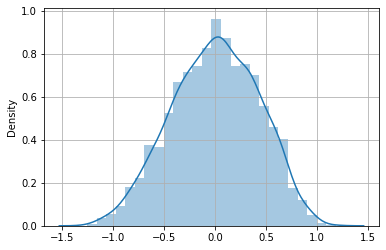

In [79]:
# assumption: Normality of the residuals/error (using distplot)
sns.distplot(lm2.resid)
plt.show()

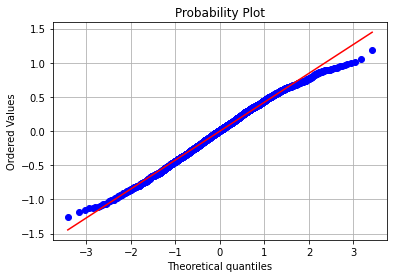

In [80]:
# assumption: Normality of the residuals/error (using Q-Q plot)
from scipy import stats
import pylab

stats.probplot(lm2.resid, dist = 'norm', plot = pylab)
pylab.show()

In [81]:
# assumption: mean of residuals/errors is zero
print(lm2.resid.mean())

-4.697290018486228e-15


In [82]:
# assumption: residuals/errors of the model should not be correlated with dependant (Y) variable
print(stats.stats.pearsonr(lm2.resid, train.ln_cards_spent))

(0.7608352389449868, 0.0)


In [83]:
lm2.resid.shape

(2217,)

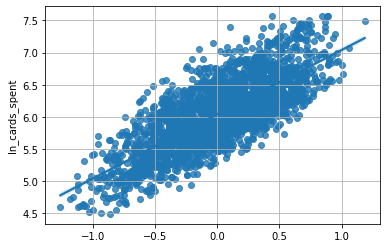

In [84]:
sns.regplot(x=lm2.resid, y=train.ln_cards_spent)
#sns.jointplot(x=train.pred_limit, y=train.ln_cards_spent)
#sns.scatterplot(x=train.pred_limit, y=train.ln_cards_spent)
plt.show()

### Machine Learning Approach

In [86]:
# method 2: required for machine learning methods available in Sklearn
train_X, test_X, train_y, test_y = train_test_split(tt[credit_cards.columns.difference(['ln_cards_spent'])], 
                                            tt['ln_cards_spent'], test_size = 0.3, random_state = 12345)

In [87]:
# Using Random Forest

In [88]:
from sklearn.ensemble import RandomForestRegressor
clf_rf= RandomForestRegressor(n_estimators=100)
clf_rf.fit(train_X, train_y)
y_pred_rf= clf_rf.predict(test_X)
acc_rf = round( clf_rf.score(test_X,test_y) * 100, 2)
print (str(acc_rf) + ' percent')

32.18 percent


In [89]:
train_X.columns

Index(['addresscat', 'carbought_1', 'card2_2', 'card2_3', 'card2_4', 'card2_5',
       'card2benefit_3', 'card2tenurecat_3', 'card_2', 'card_3', 'card_4',
       'card_5', 'cardmon', 'cardtype_2', 'cartype_0', 'carvalue', 'churn',
       'debtinc', 'default_1', 'ebill', 'edcat', 'empcat', 'gender_1',
       'hometype_3', 'internet_3', 'jobcat_5', 'jobsat', 'lncreddebt', 'lninc',
       'othdebt', 'pets', 'pets_reptiles', 'pets_saltfish', 'reason_2',
       'reason_9', 'region', 'response_03', 'retire_1', 'tenure', 'union_1'],
      dtype='object')

#### Feature Importance

In [90]:
clf_rf.feature_importances_
list(zip(train_X.columns,clf_rf.feature_importances_ ))

[('addresscat', 0.01780026438361422),
 ('carbought_1', 0.00833286942364908),
 ('card2_2', 0.016348578300914067),
 ('card2_3', 0.013902518311512775),
 ('card2_4', 0.007570512312209966),
 ('card2_5', 0.002986044366304794),
 ('card2benefit_3', 0.008234667724697746),
 ('card2tenurecat_3', 0.006609720118777696),
 ('card_2', 0.028025649612231945),
 ('card_3', 0.03290603281213031),
 ('card_4', 0.038721559724354905),
 ('card_5', 0.007209409274847696),
 ('cardmon', 0.05444419695610671),
 ('cardtype_2', 0.008228474031568046),
 ('cartype_0', 0.008741385107315052),
 ('carvalue', 0.06328155910088983),
 ('churn', 0.004950627099038237),
 ('debtinc', 0.05412738344868542),
 ('default_1', 0.006225522178818765),
 ('ebill', 0.007294738331097221),
 ('edcat', 0.02099960683188723),
 ('empcat', 0.018095530543000886),
 ('gender_1', 0.0088554253000829),
 ('hometype_3', 0.006065227469617193),
 ('internet_3', 0.0038854117881890393),
 ('jobcat_5', 0.003509647825518854),
 ('jobsat', 0.02366471897284488),
 ('lncredd

In [91]:
# Using Random Forest
#from sklearn.ensemble import RandomForestRegressor
ce=pd.DataFrame(clf_rf.feature_importances_, train_X.columns)
ce.columns=['Coefficients']
ce.sort_values('Coefficients',ascending=False,inplace=True)
ce['Coefficients']=((ce['Coefficients'])*100).round(2)
ce=ce.head(10)
#ce.to_excel('ce.xlsx')

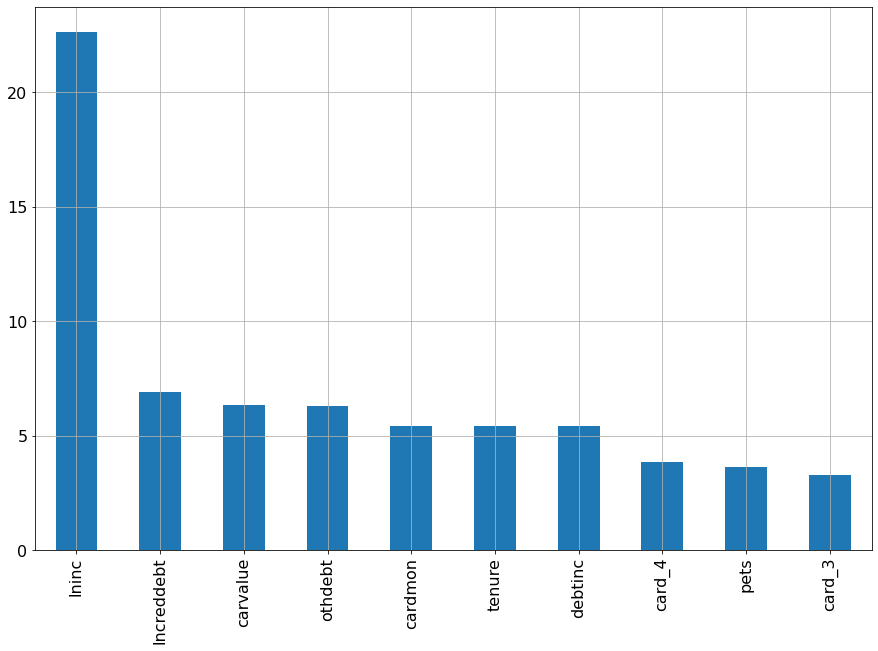

In [92]:
cece=ce.head(12)
ce.Coefficients.plot(kind='bar',figsize=(15,10),fontsize=16)
plt.show()